# 최종 프로젝트 - 감성 분류 부분
- 사용 모델 kobert
- 출처 -  http://freesearch.pe.kr/archives/4981
- git -  https://github.com/SKTBrain/KoBERT

# 시험 데이터 셋
- AI hub 감성 대화 말뭉치
- 출처 - https://aihub.or.kr/aidata/7978

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

     |████████████████████████████████| 47.3 MB 97 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 2.9 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595751 sha256=6b24093a3cedb7bb62a3ce96c03094088c8f1c521270d26d4c2ba610fa1deafc
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 5.3 MB/s 
     |████████████████████████████████| 769 kB 5.4 MB/s 
     |████████████████████████████████| 895 kB 32.4 MB/s 
     |████████████████████████████████| 3.0 MB 40.7 MB/s 


In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-t9u8citi
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-t9u8citi
     |████████████████████████████████| 132 kB 5.6 MB/s 
     |████████████████████████████████| 4.5 MB 31.8 MB/s 
     |████████████████████████████████| 3.8 MB 29.1 MB/s 
     |████████████████████████████████| 596 kB 28.7 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 6.5 MB 30.6 MB/s 
     |████████████████████████████████| 79 kB 6.2 MB/s 
     |████████████████████████████████| 8.6 MB 30.5 MB/s 
     |████████████████████████████████| 127 kB 36.5 MB/s 
  Created wheel for kobert: filename=kobert-0.2.3-py3-none-any.whl size=15674 sha256=56077b1a8b56712237493c680a026d4ca40f593f54eb73f7386aeb8d61d6ba63
  Stored in directory: /tmp/pip-ephem-wheel-cache-5cvqqhr9/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd05

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
#GPU 사용
device = torch.device("cuda:0")

In [ ]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 오류 발생
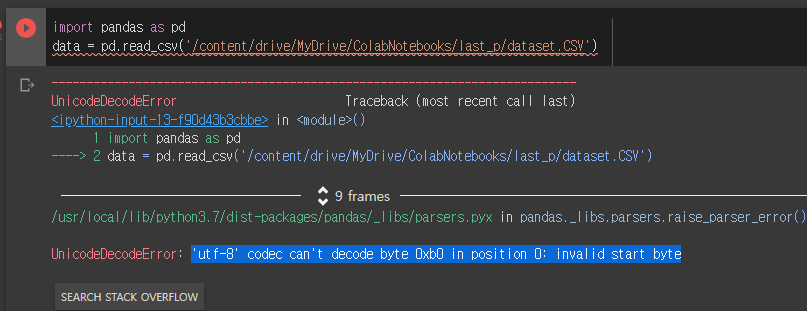

- 해결 
```
import pandas as pd
df_pop = pd.read_csv('./경로/파일.csv', encoding='cp949')
```

참고 - https://zephyrus1111.tistory.com/39

### 데이터 불러오기

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/last_p/scripts_feeling2.csv', encoding='cp949')
data

,index,script,Unnamed: 2
0,1,다람쥐와 호랑이,NaN
1,2,"추운 겨울날, 배고픈 호랑이가 작은 다람쥐를 잡았어요.",NaN
2,3,"""어흥, 배고픈데 잘됐네. 너를 잡아먹으면 되겠군.”",NaN
3,5,"“잠깐만요! 호랑이님, 저 같은 작은 다람쥐만으로는 부족하지 않으신가요? 저를 살려...",NaN
4,8,다람쥐의 말에 호랑이는 귀가 솔깃했어요.,NaN
...,...,...,...
1568,2370,"""풀잎 할머니는 행복하세요?""",안심
1569,2371,“물론. 난 더운 여름도 이겨 내고 폭풍우도 이겨 내며 작은 풀씨를 만들었어. 그 ...,기쁨
1570,2374,자세히 보니 풀잎할머니는 마치 남이 모르는 값진 보물을 품고 있는 것처럼 보였죠.,해설
1571,2375,햇볕이 쨍쨍 내리쬐는 어느 날이었답니다.,해설


### 데이터 전처리

In [ ]:
data.isnull().sum()

index           0
script          0
Unnamed: 2    923
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       1573 non-null   int64 
 1   script      1573 non-null   object
 2   Unnamed: 2  650 non-null    object
dtypes: int64(1), object(2)
memory usage: 37.0+ KB


In [ ]:
data.head(20)

,index,script,Unnamed: 2
0,1,다람쥐와 호랑이,NaN
1,2,"추운 겨울날, 배고픈 호랑이가 작은 다람쥐를 잡았어요.",NaN
2,3,"""어흥, 배고픈데 잘됐네. 너를 잡아먹으면 되겠군.”",NaN
3,5,"“잠깐만요! 호랑이님, 저 같은 작은 다람쥐만으로는 부족하지 않으신가요? 저를 살려...",NaN
4,8,다람쥐의 말에 호랑이는 귀가 솔깃했어요.,NaN
5,9,"“뭐라고? 물고기를 잔뜩 먹게 해준단 말이야?""",NaN
6,11,“네. 제가 누구예요? 꾀 많은 다람쥐잖아요. 저만 따라오세요.”,NaN
7,15,토끼는 호랑이를 연못으로 데려갔죠.,NaN
8,16,"""호랑이님의 긴 꼬리를, 자, 자, 이렇게. 이렇게. 물 속에 넣고 있으면 물고기들...",NaN
9,19,"“그래? 정말이지?""",NaN


In [ ]:
data_set = data[['script', 'Unnamed: 2']]
data_set

,script,Unnamed: 2
0,다람쥐와 호랑이,NaN
1,"추운 겨울날, 배고픈 호랑이가 작은 다람쥐를 잡았어요.",NaN
2,"""어흥, 배고픈데 잘됐네. 너를 잡아먹으면 되겠군.”",NaN
3,"“잠깐만요! 호랑이님, 저 같은 작은 다람쥐만으로는 부족하지 않으신가요? 저를 살려...",NaN
4,다람쥐의 말에 호랑이는 귀가 솔깃했어요.,NaN
...,...,...
1568,"""풀잎 할머니는 행복하세요?""",안심
1569,“물론. 난 더운 여름도 이겨 내고 폭풍우도 이겨 내며 작은 풀씨를 만들었어. 그 ...,기쁨
1570,자세히 보니 풀잎할머니는 마치 남이 모르는 값진 보물을 품고 있는 것처럼 보였죠.,해설
1571,햇볕이 쨍쨍 내리쬐는 어느 날이었답니다.,해설


In [ ]:
data_set['Unnamed: 2'].unique()

array([nan, '제목', '해설', '안심', '기쁨', '불안', '슬픔', '짜증', '분노'], dtype=object)

In [ ]:
# data_set.loc[(data_set['감정_대분류'] == "기쁨 "),'감정_대분류'] = '기쁨'
# data_set.loc[(data_set['감정_대분류'] == "불안 "),'감정_대분류'] = '불안'

data_set= data_set.dropna()
drop = data_set[data_set['Unnamed: 2']=='제목'].index
data_set = data_set.drop(drop)
data_set

,script,Unnamed: 2
924,오늘은 선생님과 장래희망에 대해서 발표하는 날이었죠.,해설
925,"""오늘 장래희망을 가장 멋지게 발표하는 사람에겐 상을 줄 거에요. 자기 희망을 잘 ...",안심
926,삼학년 이반 교실은 선생님의 말씀에 갑자기 소란스러워졌답니다.,해설
927,"""히히, 난 개그맨이 되고 싶어!""",기쁨
928,"""난 배우가 될래.""",기쁨
...,...,...
1568,"""풀잎 할머니는 행복하세요?""",안심
1569,“물론. 난 더운 여름도 이겨 내고 폭풍우도 이겨 내며 작은 풀씨를 만들었어. 그 ...,기쁨
1570,자세히 보니 풀잎할머니는 마치 남이 모르는 값진 보물을 품고 있는 것처럼 보였죠.,해설
1571,햇볕이 쨍쨍 내리쬐는 어느 날이었답니다.,해설


In [ ]:
# 전체 열 이름 입력하기
data_set.columns = ['script', 'Unnamed: 2']

# 선택하여 열 이름 변경하기
data_set = data_set.rename(columns={'Unnamed: 2':'emotion'})

In [ ]:
data_set['emotion'].unique()

array(['해설', '안심', '기쁨', '불안', '슬픔', '짜증', '분노'], dtype=object)

In [ ]:
data_set.loc[(data_set['emotion'] == "해설"),'emotion'] = 0
data_set.loc[(data_set['emotion'] == "안심"),'emotion'] = 1
data_set.loc[(data_set['emotion'] == "기쁨"),'emotion'] = 2
data_set.loc[(data_set['emotion'] == "불안"),'emotion'] = 3
data_set.loc[(data_set['emotion'] == "슬픔"),'emotion'] = 4
data_set.loc[(data_set['emotion'] == "짜증"),'emotion'] = 5
data_set.loc[(data_set['emotion'] == "분노"),'emotion'] = 6



data_list = []
for q, label in zip(data_set['script'], data_set['emotion'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [ ]:
print(data_list[0])
print(data_list[500])
print(data_list[-1])

['오늘은 선생님과 장래희망에 대해서 발표하는 날이었죠.', '0']
['"응, 지희야 안녕? 상준이도 안녕?”', '1']
['빗물의 몸이 가벼워지더니 수증기가 되어 조금씩 떠올랐어요.', '0']


In [ ]:
data_set

,script,emotion
924,오늘은 선생님과 장래희망에 대해서 발표하는 날이었죠.,0
925,"""오늘 장래희망을 가장 멋지게 발표하는 사람에겐 상을 줄 거에요. 자기 희망을 잘 ...",1
926,삼학년 이반 교실은 선생님의 말씀에 갑자기 소란스러워졌답니다.,0
927,"""히히, 난 개그맨이 되고 싶어!""",2
928,"""난 배우가 될래.""",2
...,...,...
1568,"""풀잎 할머니는 행복하세요?""",1
1569,“물론. 난 더운 여름도 이겨 내고 폭풍우도 이겨 내며 작은 풀씨를 만들었어. 그 ...,2
1570,자세히 보니 풀잎할머니는 마치 남이 모르는 값진 보물을 품고 있는 것처럼 보였죠.,0
1571,햇볕이 쨍쨍 내리쬐는 어느 날이었답니다.,0


In [ ]:
data2 = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/last_p/scripts_feeling1.csv')
data2

,feeling,script
0,해설,다람쥐와 호랑이
1,해설,"추운 겨울날, 배고픈 호랑이가 작은 다람쥐를 잡았어요."
2,기쁨,"""어흥, 배고픈데 잘됐네. 너를 잡아먹으면 되겠군.”"
3,불안,"“잠깐만요! 호랑이님, 저 같은 작은 다람쥐만으로는 부족하지 않으신가요? 저를 살려..."
4,해설,다람쥐의 말에 호랑이는 귀가 솔깃했어요.
...,...,...
918,슬픔,“흑흑흑! 그러면 여기서 기다려. 내가 맛있게 불어서 다시 나올게.”
919,해설,그러고는 물속으로 퐁당! 들어갔죠.
920,해설,"호랑이는 물속으로 들어간 자라를 기다리고, 기다리고, 또 기다리다 생각했어요."
921,슬픔,"“휴! 불쌍한 자라, 물에 빠져 죽었나봐."""


In [ ]:
data2['feeling'].unique()

array(['해설', '기쁨', '불안', '안심', '분노', '슬픔', '짜증'], dtype=object)

In [ ]:
data2.loc[(data2['feeling'] == "해설"),'feeling'] = 0
data2.loc[(data2['feeling'] == "안심"),'feeling'] = 1
data2.loc[(data2['feeling'] == "기쁨"),'feeling'] = 2
data2.loc[(data2['feeling'] == "불안"),'feeling'] = 3
data2.loc[(data2['feeling'] == "슬픔"),'feeling'] = 4
data2.loc[(data2['feeling'] == "짜증"),'feeling'] = 5
data2.loc[(data2['feeling'] == "분노"),'feeling'] = 6



data_list2 = []
for q, label in zip(data2['script'], data2['feeling'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list2.append(data)

### 학습 진행

In [ ]:
#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = data_list, data_list2

In [ ]:
print(len(dataset_train))
print(len(dataset_test))

635
923


### 임베딩

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 100
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train[0]

(array([   2, 3419, 7086, 2752, 5468, 3954, 6023, 7994, 6896, 1686, 2251,
        7794, 1407, 7096, 6885, 7275,  517,   54,    3,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(19, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 0)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### koBERT 학습 모델 구성

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 1.996922254562378 train acc 0.125
epoch 1 train acc 0.1183792372881356


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 1 test acc 0.17719907407407406


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.9823628664016724 train acc 0.09375
epoch 2 train acc 0.2290783898305085


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 2 test acc 0.6250771604938271


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.7202186584472656 train acc 0.4375
epoch 3 train acc 0.5994438559322034


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 3 test acc 0.6240354938271604


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.4463473558425903 train acc 0.625
epoch 4 train acc 0.7016684322033898


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 4 test acc 0.6306712962962963


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 1.2352573871612549 train acc 0.578125
epoch 5 train acc 0.700873940677966


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 5 test acc 0.5982638888888889


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 1.0615285634994507 train acc 0.609375
epoch 6 train acc 0.7201536016949153


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 6 test acc 0.6153163580246913


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.8960287570953369 train acc 0.703125
epoch 7 train acc 0.7525688559322034


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 7 test acc 0.6198688271604937


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.8987212777137756 train acc 0.59375
epoch 8 train acc 0.7060911016949152


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 8 test acc 0.5864197530864197


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.8719809651374817 train acc 0.671875
epoch 9 train acc 0.7609110169491525


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 9 test acc 0.6055555555555556


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.8032646775245667 train acc 0.65625
epoch 10 train acc 0.7706832627118644


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 10 test acc 0.6121913580246914


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.7223316431045532 train acc 0.703125
epoch 11 train acc 0.7769332627118644


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 11 test acc 0.606983024691358


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.8576390147209167 train acc 0.671875
epoch 12 train acc 0.7909957627118643


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 12 test acc 0.6048996913580247


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.719753623008728 train acc 0.671875
epoch 13 train acc 0.8034957627118644


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 13 test acc 0.6180555555555556


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.6849161982536316 train acc 0.71875
epoch 14 train acc 0.7768008474576271


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 14 test acc 0.6237654320987654


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 1.0426106452941895 train acc 0.625
epoch 15 train acc 0.6699947033898306


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 15 test acc 0.5546296296296297


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.857336163520813 train acc 0.578125
epoch 16 train acc 0.7377383474576271


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 16 test acc 0.591358024691358


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.7579019665718079 train acc 0.6875
epoch 17 train acc 0.7890360169491525


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 17 test acc 0.5688271604938271


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.7231559753417969 train acc 0.703125
epoch 18 train acc 0.8096133474576271


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 18 test acc 0.5834104938271605


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.6176921129226685 train acc 0.734375
epoch 19 train acc 0.8064883474576272


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 19 test acc 0.6056712962962963


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.6399418115615845 train acc 0.765625
epoch 20 train acc 0.8330508474576271


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 20 test acc 0.6000771604938271


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.49576279520988464 train acc 0.75
epoch 21 train acc 0.8014036016949152


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 21 test acc 0.5750771604938271


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.5447171330451965 train acc 0.765625
epoch 22 train acc 0.7908633474576272


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 22 test acc 0.6032021604938271


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 0.5683497190475464 train acc 0.796875
epoch 23 train acc 0.8452860169491526


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 23 test acc 0.5681712962962963


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 24 batch id 1 loss 0.7436895370483398 train acc 0.75
epoch 24 train acc 0.8583156779661018


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 24 test acc 0.6104938271604937


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 25 batch id 1 loss 0.5421603322029114 train acc 0.765625
epoch 25 train acc 0.8739406779661018


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 25 test acc 0.5965663580246914


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 26 batch id 1 loss 0.4782979190349579 train acc 0.78125
epoch 26 train acc 0.8408633474576271


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 26 test acc 0.6198688271604937


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 27 batch id 1 loss 1.1361970901489258 train acc 0.640625
epoch 27 train acc 0.8598781779661018


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 27 test acc 0.6015046296296297


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 28 batch id 1 loss 0.42464596033096313 train acc 0.8125
epoch 28 train acc 0.9067531779661018


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 28 test acc 0.6108796296296296


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 29 batch id 1 loss 0.37446701526641846 train acc 0.828125
epoch 29 train acc 0.9225105932203389


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 29 test acc 0.5938271604938271


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 30 batch id 1 loss 0.4175104796886444 train acc 0.875
epoch 30 train acc 0.9242055084745763


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 30 test acc 0.5973379629629629


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 31 batch id 1 loss 0.3876263499259949 train acc 0.859375
epoch 31 train acc 0.9067531779661018


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 31 test acc 0.578587962962963


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 32 batch id 1 loss 0.37151309847831726 train acc 0.859375
epoch 32 train acc 0.9335805084745763


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 32 test acc 0.603587962962963


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 33 batch id 1 loss 0.261813759803772 train acc 0.875
epoch 33 train acc 0.9337129237288135


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 33 test acc 0.5921296296296297


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 34 batch id 1 loss 0.23129022121429443 train acc 0.890625
epoch 34 train acc 0.9477754237288135


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 34 test acc 0.6133487654320987


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 35 batch id 1 loss 0.2556285560131073 train acc 0.859375
epoch 35 train acc 0.9605402542372881


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 35 test acc 0.6011188271604938


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 36 batch id 1 loss 0.1116676852107048 train acc 0.984375
epoch 36 train acc 0.9779925847457627


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 36 test acc 0.6046296296296296


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 37 batch id 1 loss 0.11801251769065857 train acc 0.984375
epoch 37 train acc 0.9795550847457626


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 37 test acc 0.5983796296296297


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 38 batch id 1 loss 0.09674376249313354 train acc 0.984375
epoch 38 train acc 0.98125


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 38 test acc 0.5852237654320988


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 39 batch id 1 loss 0.08513182401657104 train acc 0.984375
epoch 39 train acc 0.9759004237288135


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 39 test acc 0.600462962962963


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 40 batch id 1 loss 0.26315510272979736 train acc 0.890625
epoch 40 train acc 0.9717425847457626


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 40 test acc 0.5890046296296296


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 41 batch id 1 loss 0.11853665858507156 train acc 0.984375
epoch 41 train acc 0.9859375


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 41 test acc 0.5969521604938272


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 42 batch id 1 loss 0.23019246757030487 train acc 0.921875
epoch 42 train acc 0.9778601694915254


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 42 test acc 0.5956404320987654


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 43 batch id 1 loss 0.10549034923315048 train acc 0.984375
epoch 43 train acc 0.99375


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 43 test acc 0.6046296296296296


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 44 batch id 1 loss 0.07621221244335175 train acc 0.96875
epoch 44 train acc 0.9921875


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 44 test acc 0.612692901234568


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 45 batch id 1 loss 0.024204878136515617 train acc 1.0
epoch 45 train acc 0.99375


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 45 test acc 0.599537037037037


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 46 batch id 1 loss 0.03125516325235367 train acc 0.984375
epoch 46 train acc 0.996875


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 46 test acc 0.5873070987654321


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 47 batch id 1 loss 0.020516492426395416 train acc 1.0
epoch 47 train acc 0.9984375


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 47 test acc 0.6095679012345679


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 48 batch id 1 loss 0.014814860187470913 train acc 1.0
epoch 48 train acc 0.9984375


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 48 test acc 0.6078703703703704


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 49 batch id 1 loss 0.013131311163306236 train acc 1.0
epoch 49 train acc 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 49 test acc 0.612037037037037


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 50 batch id 1 loss 0.012418007478117943 train acc 1.0
epoch 50 train acc 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 50 test acc 0.6078703703703704


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 51 batch id 1 loss 0.0104417335242033 train acc 1.0
epoch 51 train acc 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 51 test acc 0.6145061728395061


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 52 batch id 1 loss 0.010028337128460407 train acc 1.0
epoch 52 train acc 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 52 test acc 0.612037037037037


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 53 batch id 1 loss 0.010357833467423916 train acc 1.0
epoch 53 train acc 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### 테스트

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("기쁨")
            elif np.argmax(logits) == 1:
                test_eval.append("불안")
            elif np.argmax(logits) == 2:
                test_eval.append("당황")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔")
            elif np.argmax(logits) == 4:
                test_eval.append("분노")
            elif np.argmax(logits) == 5:
                test_eval.append("상처")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
# save
torch.save(model, '/content/drive/MyDrive/ColabNotebooks/last_p/custom_kobert_model.pt')

torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/last_p/custom_kobert_state_dict.pt')

In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == 0 :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 아이고 호랑이님!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


>> 입력하신 내용에서 분노 느껴집니다.


하고싶은 말을 입력해주세요 : 아이고 호랑이님! 
>> 입력하신 내용에서 분노 느껴집니다.


하고싶은 말을 입력해주세요 : 추운 겨울날, 배고픈 호랑이가 작은 다람쥐를 잡았어요.
>> 입력하신 내용에서 기쁨 느껴집니다.


하고싶은 말을 입력해주세요 : "어흥, 배고픈데 잘됐네. 너를 잡아먹으면 되겠군.”
>> 입력하신 내용에서 슬픔 느껴집니다.


하고싶은 말을 입력해주세요 : 그때 비단신 옆에 조용히 있던 풀잎 할머니가 혼잣말처럼 중얼거렸답니다.
>> 입력하신 내용에서 기쁨 느껴집니다.




KeyboardInterrupt: ignored